# Improving Data Quality in Medical Imaging

## Use standard AI tools to predict a patient's body orientation in CT scans so that discrepancies in manually entered data can be automatically identified and corrected.

When a patient has a CT scan taken, a special device uses X-rays to take measurements from a variety of angles which are then computationally reconstructed into a 3D matrix of intensity values. Each layer of the matrix shows one very thin "slice" of the patient's body. This data is saved in an industry-standard format known as DICOM, which saves the image matrix in a set binary format and then wraps this data with a huge variety of metadata tags.

Some of these fields (e.g. hardware manufacturer, device serial number, voltage) are usually correct because they are automatically read from hardware and software settings

The problem is that many important fields must be added manually by the technician and are therefore subject to human error factors like confusion, fatigue, loss of situational awareness, and simple typos.

In [39]:
!python --version
%matplotlib inline

Python 3.6.2 :: Anaconda custom (64-bit)


In [26]:

import os
import sys
import pandas as pd
import numpy as np
import glob
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

from IPython.display import Image
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

In [27]:
NUM_CLASSES = 4
IMG_SIZE_PX = 64 
LEARNING_RATE = 1e-3
BATCH_SIZE = 16
EPOCHS = 500


In [28]:
# read training file names
def find_imgfiles(path):
    path = path + "/" + "*.png"
    print(path)
    return glob.glob(path)
    
    

train_filenames = find_imgfiles("train")
len(train_filenames)

train/*.png


20000

In [29]:
## Read  the training image label data

train_labels_df = pd.read_csv('train_labels.csv')
train_labels_df.count()

## convert labels into vectors in the range [0, NUM_CLASSES]
labels = np_utils.to_categorical(train_labels_df['orientation'], NUM_CLASSES)
print(labels.shape)
tr_labels = labels.astype(int)
#tr_labels[0:10], train_labels_df[0:10]


(20000, 4)


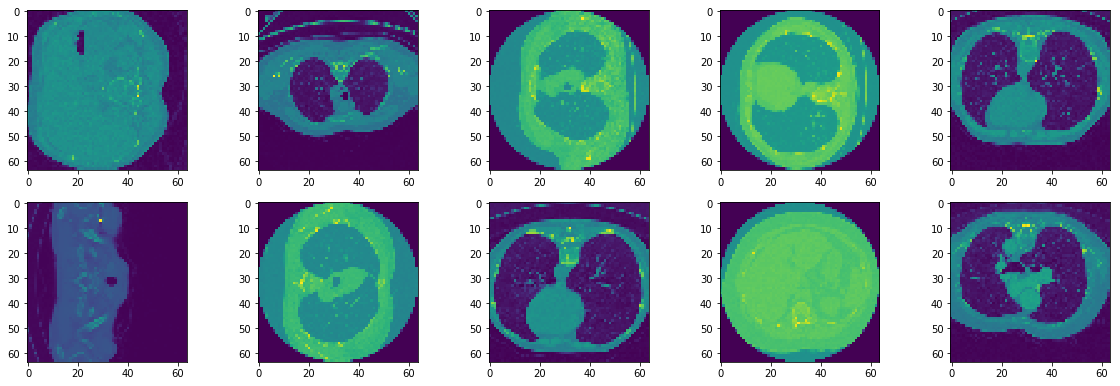

In [30]:
## preview images to ensure imaeges are loading properly
im = []
IMG_COUNT = 10
for i in range(IMG_COUNT):
    im.append(mpimg.imread(train_filenames[i]))


plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(im):
    plt.subplot(len(im) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [31]:
## read the training image data
def find_imgfiles(path):
    path = path + "/" + "*.png"
    return glob.glob(path)

train_filenames = find_imgfiles("train")
print("Total training file names ", len(train_filenames))

## Train Image data 
TRAIN_IMG_COUNT = 20000
im = []
for i in range(TRAIN_IMG_COUNT):
    im.append(np.array(mpimg.imread(train_filenames[i])).flatten())
    
image_np = np.array(im, np.float64)
print("Training image size ", image_np.shape)


Total training file names  20000
Training image size  (20000, 4096)


In [32]:
print("training/testing split...")
(trainData, testData, trainLabels, testLabels) = train_test_split(image_np, tr_labels[0:TRAIN_IMG_COUNT], 
                                                                  test_size=0.25, random_state=42)

print("Train Test data size")
print(trainData.shape, testData.shape, trainLabels.shape, testLabels.shape, image_np.shape[1])

training/testing split...
Train Test data size
(15000, 4096) (5000, 4096) (15000, 4) (5000, 4) 4096


In [33]:
## define ultrasimple keras based neural network
## A feed forward NN with 4096 inputs x 764 hidden nodes (layer 1) x 384 hidden nodes (layer 2) x 4 output nodes

model = Sequential()
model.add(Dense(768, input_dim=image_np.shape[1], init="uniform", activation="relu"))
model.add(Dense(384, activation="relu", kernel_initializer="uniform"))
model.add(Dense(NUM_CLASSES))
model.add(Activation("softmax"))



C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(768, input_dim=4096, activation="relu", kernel_initializer="uniform")`
  """


In [34]:

class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('val_acc'))
        
history = AccuracyHistory()

earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=3, \
                          verbose=1, mode='auto')


In [35]:
# train the model using SGD
print("Compiling model...")
sgd = SGD(lr=LEARNING_RATE)
model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])
model.fit(trainData, trainLabels, epochs=EPOCHS, 
          batch_size=BATCH_SIZE, verbose=1,
         validation_data=(testData, testLabels),
          callbacks=[history,earlystop])

Compiling model...
Train on 15000 samples, validate on 5000 samples
Epoch 1/500
15000/15000 [==============================] - 30s 2ms/step - loss: 0.4780 - acc: 0.7560 - val_loss: 0.3985 - val_acc: 0.7899
Epoch 2/500
15000/15000 [==============================] - 29s 2ms/step - loss: 0.3418 - acc: 0.8527 - val_loss: 0.2940 - val_acc: 0.8929
Epoch 3/500
15000/15000 [==============================] - 29s 2ms/step - loss: 0.2599 - acc: 0.9145 - val_loss: 0.2287 - val_acc: 0.9299
Epoch 4/500
15000/15000 [==============================] - 29s 2ms/step - loss: 0.2148 - acc: 0.9322 - val_loss: 0.1947 - val_acc: 0.9405
Epoch 5/500
15000/15000 [==============================] - 34s 2ms/step - loss: 0.1881 - acc: 0.9405 - val_loss: 0.1752 - val_acc: 0.9445
Epoch 6/500
15000/15000 [==============================] - 33s 2ms/step - loss: 0.1703 - acc: 0.9445 - val_loss: 0.1597 - val_acc: 0.9480
Epoch 7/500
15000/15000 [==============================] - 33s 2ms/step - loss: 0.1571 - acc: 0.9489 - v

15000/15000 [==============================] - 33s 2ms/step - loss: 0.0427 - acc: 0.9875 - val_loss: 0.0478 - val_acc: 0.9862
Epoch 60/500
15000/15000 [==============================] - 33s 2ms/step - loss: 0.0424 - acc: 0.9875 - val_loss: 0.0495 - val_acc: 0.9858
Epoch 61/500
15000/15000 [==============================] - 33s 2ms/step - loss: 0.0418 - acc: 0.9879 - val_loss: 0.0480 - val_acc: 0.9859
Epoch 62/500
15000/15000 [==============================] - 33s 2ms/step - loss: 0.0414 - acc: 0.9880 - val_loss: 0.0479 - val_acc: 0.9865
Epoch 63/500
15000/15000 [==============================] - 33s 2ms/step - loss: 0.0411 - acc: 0.9879 - val_loss: 0.0482 - val_acc: 0.9856
Epoch 64/500
15000/15000 [==============================] - 33s 2ms/step - loss: 0.0405 - acc: 0.9884 - val_loss: 0.0461 - val_acc: 0.9867
Epoch 65/500
15000/15000 [==============================] - 33s 2ms/step - loss: 0.0400 - acc: 0.9882 - val_loss: 0.0466 - val_acc: 0.9862
Epoch 66/500
15000/15000 [==============

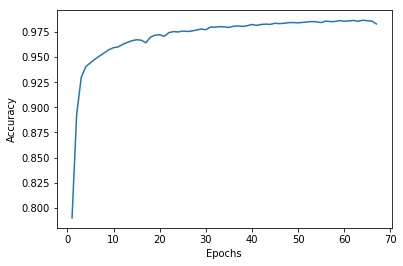

In [37]:
plt.plot(range(1,67+1), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [38]:
score = model.evaluate(testData, testLabels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0524189821452
Test accuracy: 0.98295



# Can we make it better?

In [14]:
## Try convnet model
## source http://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/

model2 = Sequential()
model2.add(Conv2D(128, kernel_size=(4, 4), strides=(1, 1),
                 activation='relu',
                 input_shape=(IMG_SIZE_PX, IMG_SIZE_PX, 1)))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Conv2D(64, (4, 4), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(1000, activation='relu'))
model2.add(Dense(NUM_CLASSES, activation='softmax'))

In [15]:
## reshape image input data for Conv Net

trainData = trainData.reshape(trainData.shape[0], IMG_SIZE_PX, IMG_SIZE_PX, 1)
testData = testData.reshape(testData.shape[0], IMG_SIZE_PX, IMG_SIZE_PX, 1)
print("Train Test data size")
print(trainData.shape, testData.shape, trainLabels.shape, testLabels.shape, image_np.shape[1])

Train Test data size
(16000, 64, 64, 1) (4000, 64, 64, 1) (16000, 4) (4000, 4) 4096


In [16]:
CONV_EPOCHS = 8
## compile and fit the model
model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

model2.fit(trainData, trainLabels,
          batch_size=BATCH_SIZE,
          epochs=CONV_EPOCHS,
          verbose=1,
          validation_data=(testData, testLabels),
          callbacks=[history,earlystop])


Train on 16000 samples, validate on 4000 samples
Epoch 1/8
16000/16000 [==============================] - 711s 44ms/step - loss: 0.1381 - acc: 0.9482 - val_loss: 0.0422 - val_acc: 0.9885
Epoch 2/8
16000/16000 [==============================] - 720s 45ms/step - loss: 0.0452 - acc: 0.9868 - val_loss: 0.1083 - val_acc: 0.9738
Epoch 3/8
16000/16000 [==============================] - 705s 44ms/step - loss: 0.0293 - acc: 0.9918 - val_loss: 0.0292 - val_acc: 0.9925
Epoch 4/8
16000/16000 [==============================] - 703s 44ms/step - loss: 0.0241 - acc: 0.9922 - val_loss: 0.0728 - val_acc: 0.9785
Epoch 5/8
16000/16000 [==============================] - 684s 43ms/step - loss: 0.0175 - acc: 0.9950 - val_loss: 0.0431 - val_acc: 0.9888
Epoch 6/8
16000/16000 [==============================] - 706s 44ms/step - loss: 0.0130 - acc: 0.9959 - val_loss: 0.0154 - val_acc: 0.9965
Epoch 7/8
16000/16000 [==============================] - 712s 44ms/step - loss: 0.0096 - acc: 0.9970 - val_loss: 0.0229 - v

Test loss: 0.0246741913764
Test accuracy: 0.9955


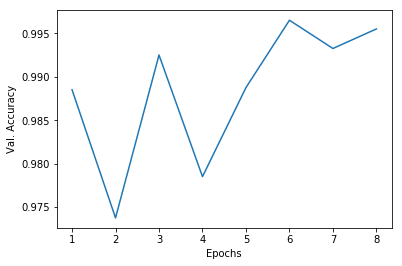

In [17]:
score = model2.evaluate(testData, testLabels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, CONV_EPOCHS + 1), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Val. Accuracy')
plt.show()

In [18]:
## submission dataframe
submission_df = pd.read_csv('submission_format.csv')
submission_df.count()

id             20000
orientation    20000
dtype: int64

In [19]:
## run against actual test data
# read training file names

test_filenames = find_imgfiles("test")
len(test_filenames)



20000

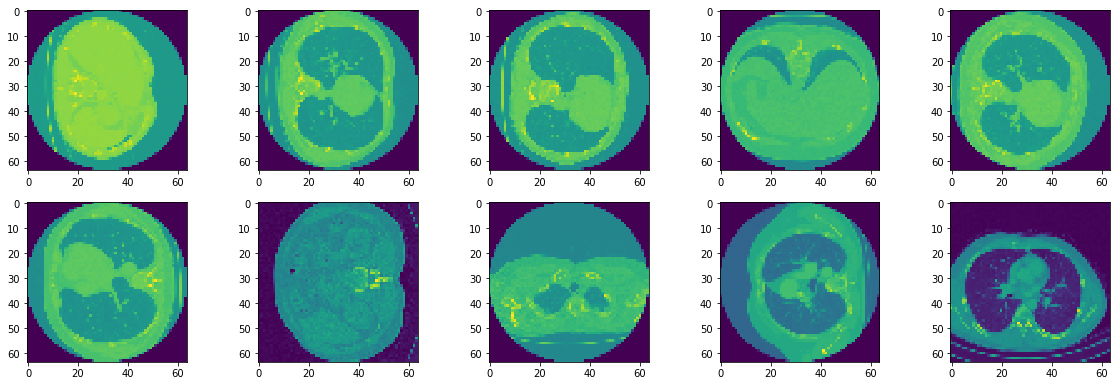

In [20]:
## preview images to ensure imaeges are loading properly
im = []
IMG_COUNT = 10
for i in range(IMG_COUNT):
    im.append(mpimg.imread(test_filenames[i]))


plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(im):
    plt.subplot(len(im) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [21]:
val_im = []
for i in range(len(test_filenames)):
    val_im.append(np.array(mpimg.imread(train_filenames[i])))
    
val_image_np = np.array(val_im, np.float64)

val_img_data = val_image_np.reshape(val_image_np.shape[0], IMG_SIZE_PX, IMG_SIZE_PX, 1)
print("Val image size ", val_img_data.shape)

Val image size  (20000, 64, 64, 1)


In [22]:
pred_y = model2.predict(val_img_data)

In [23]:
pred_y[5], pred_y[5].argmax(axis=0)

for i in range(len(test_filenames)):
    submission_df['orientation'][i] = pred_y[i].argmax(axis=0)
    


In [24]:
submission_df.to_csv("submit.3.csv", index=False)